In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import scipy
import os
import glob
import seaborn as sns
import itertools
import gc
import pickle
from nptdms import TdmsFile
from scipy import stats
from natsort import natsorted
from tqdm import tqdm

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import scienceplots

matplotlib.rcParams['text.usetex'] = True
plt.rcParams["text.usetex"] = True
# import seaborn as sns
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline

np.random.seed(16)
matplotlib.rcParams['figure.dpi'] = 300

plt.style.use(['science','nature'])
plt.rcParams['figure.constrained_layout.use'] = True

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["Open","Arc","Short","Normal"])

import sys
sys.path.append('../.')
# from pydub import AudioSegment
import itertools
import string
import glob
import subprocess
import seedir
from utils.preprocessing import one_column,two_column,cm_std,cm_bright,cm_mark,cm_highCon,centimeter
from utils.preprocessing import print_tdms_structure,split_pulses_by_interval,getShiftMean
mpl.rcParams.update(two_column)
from MyDataset import sampling_rate_ae,sampling_rate_vib, project_dir, project_name, data_dir, dataDir_ae, dataDir_vib, alphabet

## Accuracy results

only difference in 

    - input_type


In [7]:
allowed_input_types=['ae_spec','vib_spec','ae_spec+ae_features','vib_spec+vib_features','ae_spec+ae_features+vib_spec+vib_features','all']

model_name = []
folds = 10
repeat = 1
max_epochs = 9

In [21]:
def get_hist_data(hist_dir, model_name, folds, max_epochs=100):
    train_acc = []
    test_acc = []
    for i in range(folds):
        file_path = f"{model_name}_fold{i}_of_folds{folds}.csv"
        file_path = os.path.join(hist_dir, file_path)
        # print(f"{file_path}")
        # print(f"{file_path},{os.listdir(file_path)}")
        df = pd.read_csv(file_path, index_col=0)
        df = df[~df.index.get_level_values(0).duplicated(keep="last")]
        train_acc.append((1-df["train_loss"][max_epochs]))
        test_acc.append((1-df["test_loss"][max_epochs]))
    return train_acc, test_acc

def generate_hist_df(
    hist_dir, model_name, folds, max_epochs
):
    train_acc_list = []
    test_acc_list = []
    fold_i_list = []
    model_list = []

    for _model_name in model_name:
        train_acc, test_acc = get_hist_data(
            hist_dir, _model_name, folds, max_epochs
        )
        for i in range(folds):
            fold_i_list.append(i)
            train_acc_list.append(train_acc[i])
            test_acc_list.append(test_acc[i])
            model_list.append(_model_name)

    df = pd.DataFrame()
    df["Input Type"] = model_list
    df["Train Acc"] = train_acc_list
    df["Test Acc"] = test_acc_list
    df["Fold Index"] = fold_i_list

    new_df = pd.concat([df, df])
    new_df["Acc"] = pd.concat([df["Train Acc"], df["Test Acc"]])
    new_df["Acc type"] = ["Train"] * len(df) + ["Test"] * len(df)
    new_df.index = range(len(new_df))
    return new_df

In [22]:
his_dir = os.path.join(os.pardir,"lfs","train_his")
df = generate_hist_df(his_dir,allowed_input_types,folds=folds,max_epochs=max_epochs)
df

,Input Type,Train Acc,Test Acc,Fold Index,Acc,Acc type
0,ae_spec,0.999769,0.999769,0,0.999769,Train
1,ae_spec,0.999991,0.999982,1,0.999991,Train
2,ae_spec,0.999825,0.999707,2,0.999825,Train
3,ae_spec,0.999994,0.999995,3,0.999994,Train
4,ae_spec,0.999991,0.999983,4,0.999991,Train
...,...,...,...,...,...,...
115,all,0.999207,0.999407,5,0.999407,Test
116,all,0.999568,0.999204,6,0.999204,Test
117,all,0.999292,0.998952,7,0.998952,Test
118,all,0.999627,0.999729,8,0.999729,Test


C:\Users\mingwucn\AppData\Local\Temp\ipykernel_42096\2704487081.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.violinplot(
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_42096\2704487081.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]])
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_42096\2704487081.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([('\n').join(x.split('_')) for x in xTickLabels])


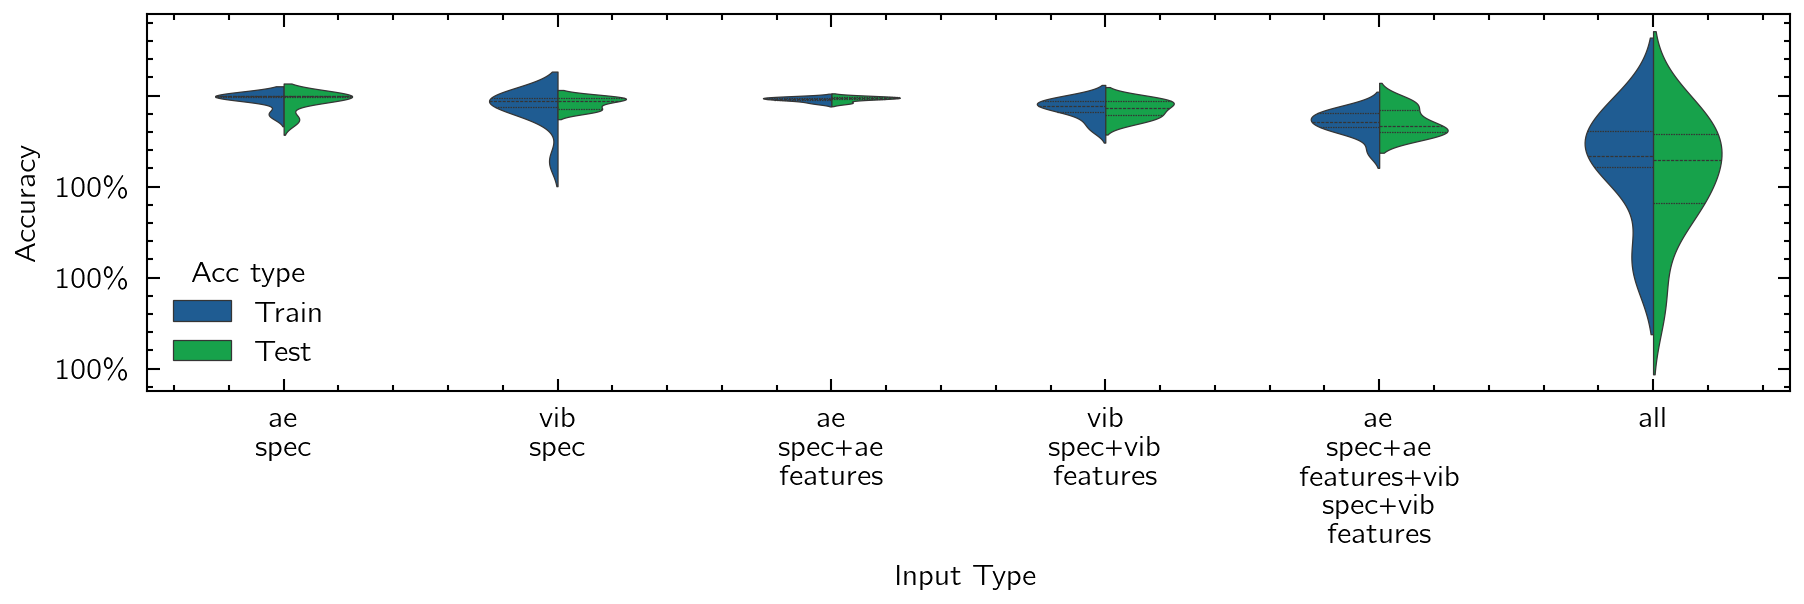

In [24]:
plt.rcParams.update(one_column)
plt.rcParams['figure.constrained_layout.use'] = True
fig,ax = plt.subplots(figsize=(6.0,2))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    # data=df[df["Model"]=="CNN"],
    data=df,
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax,
    linewidth=0.3,
    width = 0.5,
    palette = ['#0C5DA5', '#00B945', 'yellow'],
)
ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]]) 
xTickLabels = allowed_input_types
ax.set_xticklabels([('\n').join(x.split('_')) for x in xTickLabels]) 
ax.set_ylabel("Accuracy")
# plt.savefig(os.path.join(os.pardir,"CIRP ISEM 2025","image","raw_acc_vs_model.png"),dpi=300)
plt.show()

In [ ]:
np.asarray(time_series_length)/sampling_rate*1e3

array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ])

C:\Users\mingwucn\AppData\Local\Temp\ipykernel_19972\2692862545.py:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.violinplot(
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_19972\2692862545.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]])
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_19972\2692862545.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x:.2f}" for x in xTickLabels])


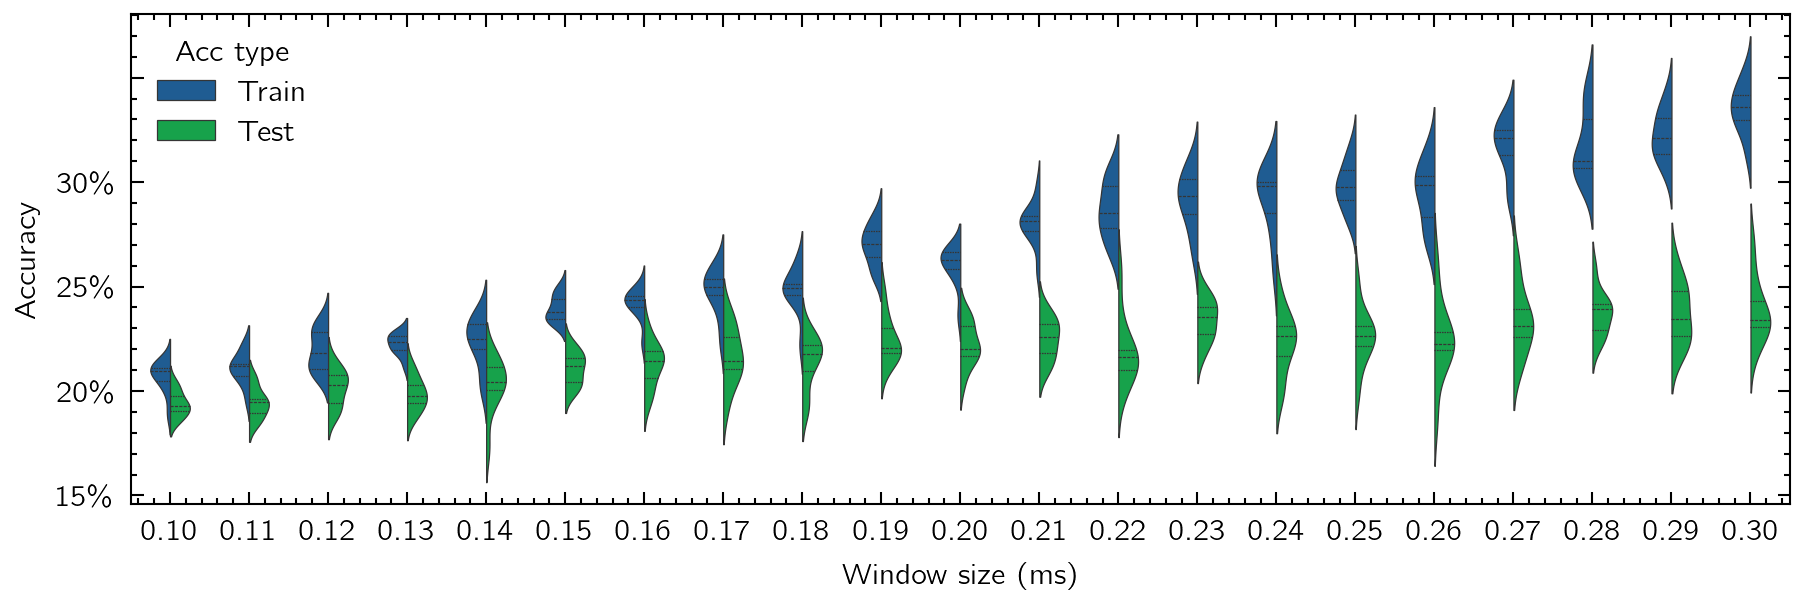

C:\Users\mingwucn\AppData\Local\Temp\ipykernel_19972\2692862545.py:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.violinplot(
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_19972\2692862545.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]])
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_19972\2692862545.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x:.2f}" for x in xTickLabels])


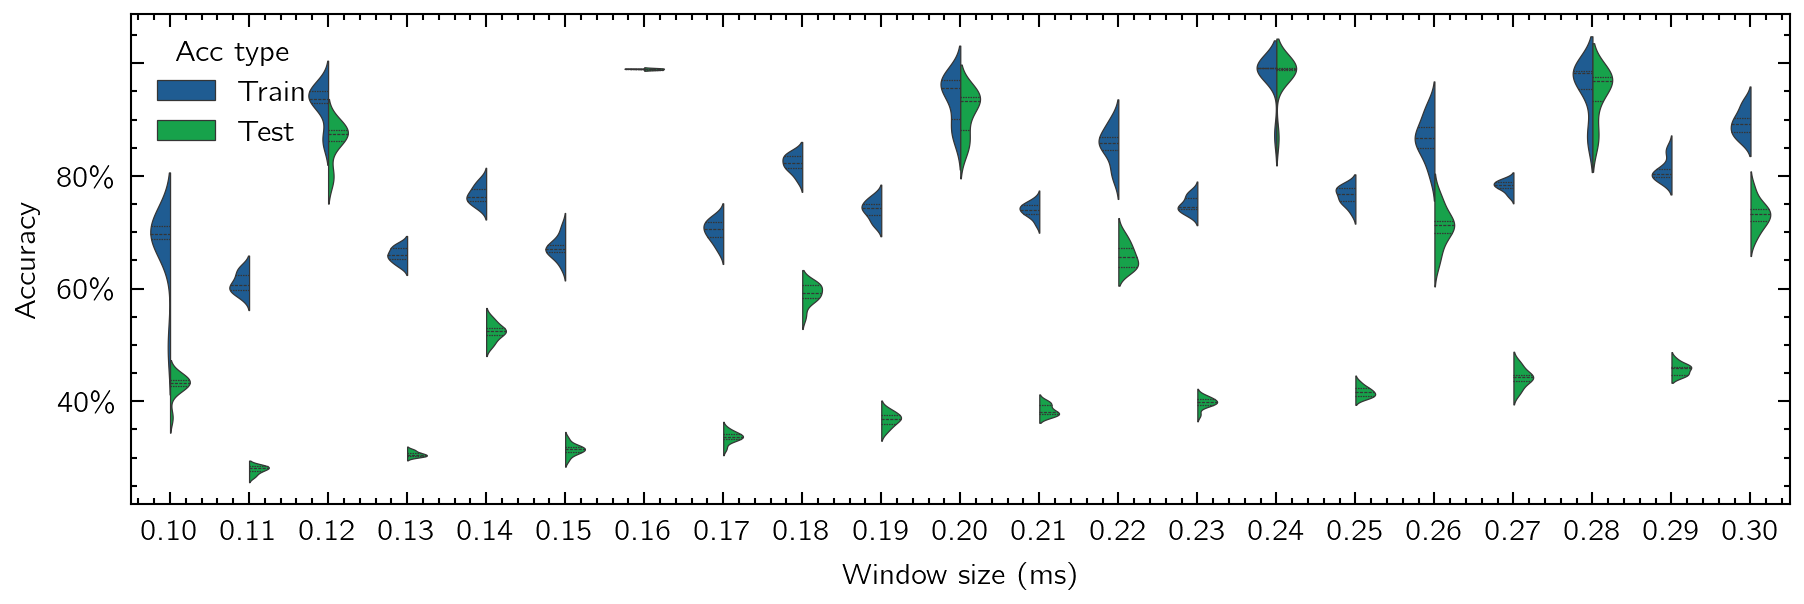

C:\Users\mingwucn\AppData\Local\Temp\ipykernel_19972\2692862545.py:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.violinplot(
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_19972\2692862545.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]])
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_19972\2692862545.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x:.2f}" for x in xTickLabels])


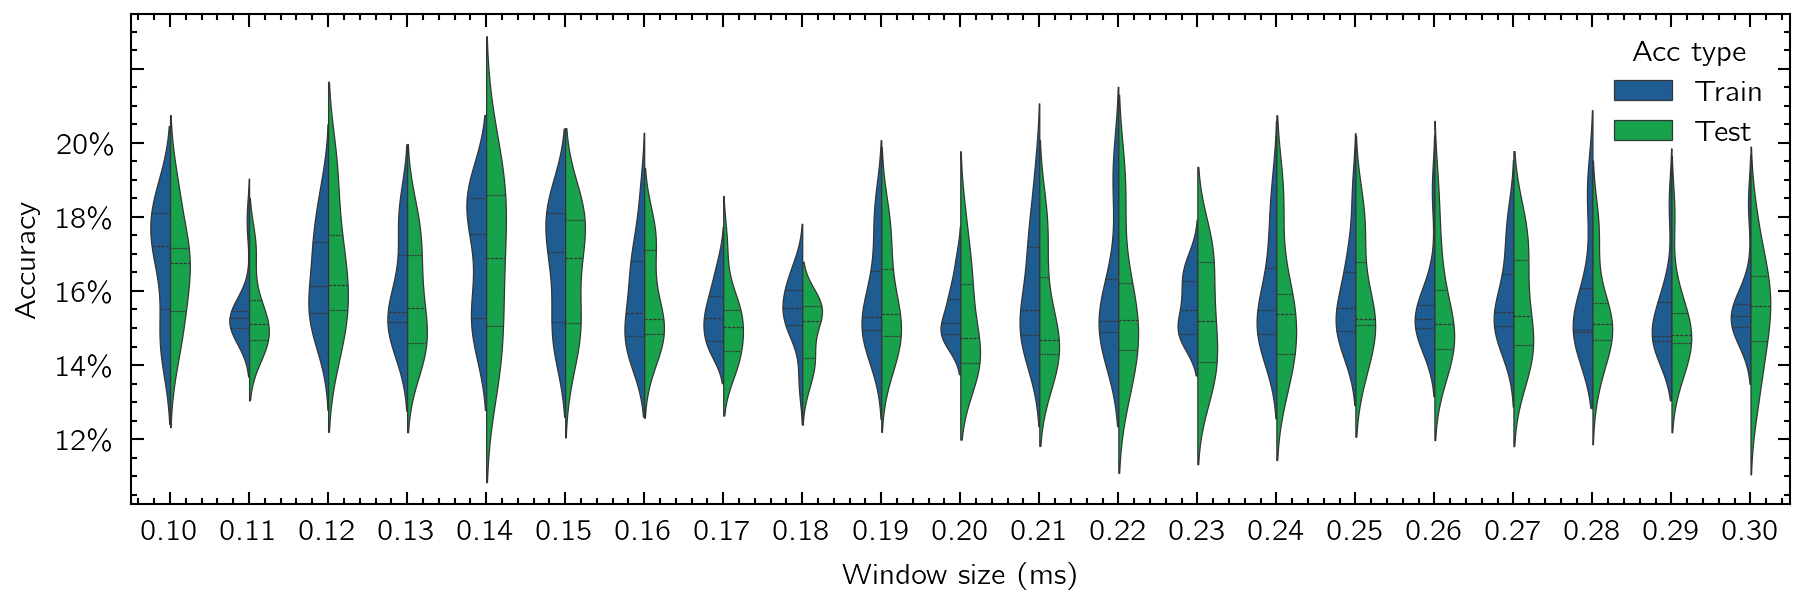

In [7]:
for _model_name in model_name:
    plt.rcParams.update(two_column)
    plt.rcParams['figure.constrained_layout.use'] = True
    fig,ax = plt.subplots(figsize=(6.0,2))
    snsdf = sns.load_dataset("tips")
    ax = sns.violinplot(
        data=df[df["Model"]==f"{_model_name}"],
        # data=df,
        x="Window size",
        y="Acc",
        hue="Acc type",
        split=True,
        saturation=0.75,
        density_norm="width",
        hue_order=["Train", "Test"],
        dodge=True,
        inner='quartile',
        ax=ax,
        linewidth=0.3,
        width = 0.5,
        palette = ['#0C5DA5', '#00B945', 'yellow'],
    )
    ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]]) 
    xTickLabels = list(np.asarray(time_series_length)/sampling_rate*1e3)

    ax.set_xticklabels([f"{x:.2f}" for x in xTickLabels]) 
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Window size (ms)")
    plt.savefig(os.path.join(os.pardir,"CIRP ISEM 2025","image",f"raw_{_model_name}_acc_vs_windowSize.png"),dpi=600)
    plt.show()

In [ ]:
plt.rcParams.update(two_column)
plt.rcParams['figure.constrained_layout.use'] = True
fig,ax = plt.subplots(figsize=(6.8,2))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[df["Model"]=="CNN"],
    # data=df
    x="Window size",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax,
    linewidth=0.3,
    width = 0.5,
    palette = ['#0C5DA5', '#00B945', 'yellow'],
)
ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]]) 
xTickLabels = list(np.asarray(time_series_length)/sampling_rate*1e3)

ax.set_xticklabels([f"{x:.2f}" for x in xTickLabels]) 
ax.set_ylabel("Accuracy")
plt.savefig(os.path.join(os.pardir,"CIRP ISEM 2025","img","raw_res15_acc_vs_windowSize.png"),dpi=300)
plt.show()

In [48]:
max_epochs=50
his_dir = os.path.join(os.pardir,"lfs","weights/hist")
model_name= ["CNN"]
acoustic_type =['ae','mic'] 
context_type = []
# context_type = ['energy']
output_type = ['position']
folds = 10

df = generate_hist_df(his_dir,model_name,acoustic_type,context_type,output_type,folds,max_epochs)
df['Input Type'] = df['Input type'].str.replace('+', '\n')
df[df['Input Type']=='ae'].describe(), df[df['Input Type']=='mic'].describe()

(       Train Acc   Test Acc  Fold index        Acc
 count  20.000000  20.000000   20.000000  20.000000
 mean    0.996888   0.996558    4.500000   0.996723
 std     0.000260   0.000546    2.946898   0.000460
 min     0.996149   0.995577    0.000000   0.995577
 25%     0.996899   0.996220    2.000000   0.996482
 50%     0.996966   0.996623    4.500000   0.996913
 75%     0.997006   0.997024    7.000000   0.997011
 max     0.997069   0.997346    9.000000   0.997346,
        Train Acc   Test Acc  Fold index        Acc
 count  20.000000  20.000000   20.000000  20.000000
 mean    0.859849   0.814344    4.500000   0.837097
 std     0.007828   0.012884    2.946898   0.025663
 min     0.845723   0.784864    0.000000   0.784864
 25%     0.855213   0.807463    2.000000   0.820733
 50%     0.859663   0.820331    4.500000   0.836767
 75%     0.863644   0.824192    7.000000   0.859533
 max     0.874014   0.827811    9.000000   0.874014)

C:\Users\mingwucn\AppData\Local\Temp\ipykernel_12488\857493326.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.violinplot(
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_12488\857493326.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]])
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_12488\857493326.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x for x in xTickLabels])


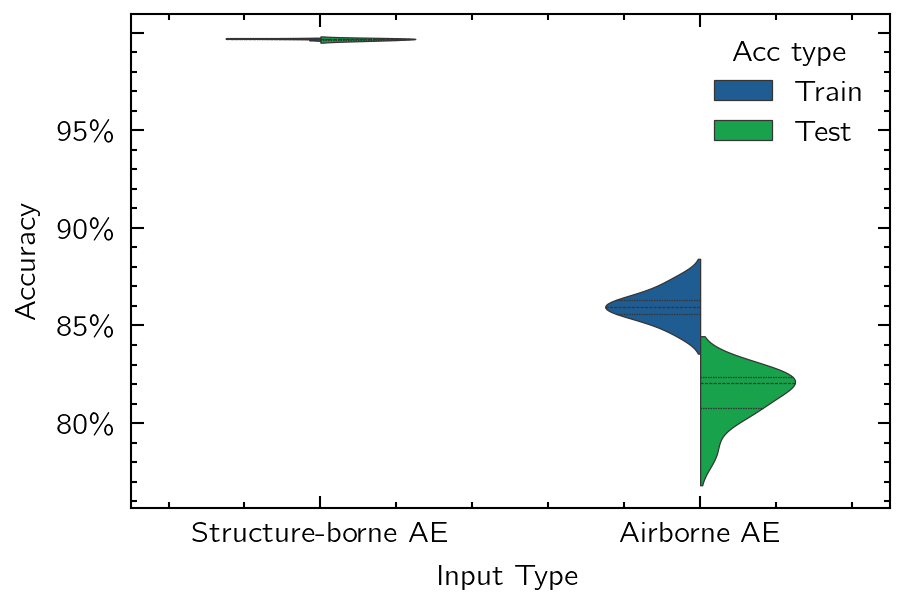

In [5]:
plt.rcParams.update(one_column)
plt.rcParams['figure.constrained_layout.use'] = True
fig,ax = plt.subplots(figsize=(3.0,2))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[df["Model"]=="CNN"],
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax,
    linewidth=0.3,
    width = 0.5,
    palette = ['#0C5DA5', '#00B945', 'yellow'],
)
ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]]) 
xTickLabels = ["Structure-borne AE","Airborne AE"]
ax.set_xticklabels([x for x in xTickLabels]) 
ax.set_ylabel("Accuracy")
plt.savefig(f"../outputs/raw_acc_ae_mic_position.png",dpi=300)
plt.show()

### Mic